In [28]:
from bs4 import BeautifulSoup 
import requests 
import re
from scipy.integrate import odeint, solve_ivp
from scipy.stats import chisquare, chi2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize,curve_fit
from sklearn.metrics import r2_score, mean_squared_error as mse

# Get the data
Url's of interesting countries, in our scenarion it will be Poland, Malysia and Belgium.

In [29]:
bg = 'https://www.worldometers.info/coronavirus/country/belgium/'
mal = 'https://www.worldometers.info/coronavirus/country/malaysia/'
pl = 'https://www.worldometers.info/coronavirus/country/poland/'

1. Get the content of page

2. Use regexp to get this kind of data: <br>
&emsp; name: 'Recovery Rate',<br>
&emsp; color: '#8ACA2B',<br>
&emsp; lineWidth: 5,<br>
&emsp; data: [ numbers ]

3. Split names and data

4. Make data more userfirendly - to floats and then to np.array

5. Names of each array

6. Get dates

In [30]:
def get_data(url):
    #1
    page = requests.get(url) 
    #2
    names = re.findall(r'series: \[\{\s*name: \'([a-zA-Z\s ]*)\'[a-zA-Z\#0-9\s\n\,\.\'\:\- ]*data: \[([0-9\,\s\.null\- ]*)\]', page.text)
    #3
    datas = [n[1] for n in names]
    names = [n[0] for n in names]
    #4
    datas = [d.split(',') for d in datas]
    datas = [[ 0 if d == 'null' else float(d) for d in data] for data in datas]
    datas = np.nan_to_num(datas,0)
    datas = np.array(datas)
    datas[datas<0]=0
    print('datas shape:',datas.shape)
    #5
    for i, n in enumerate(names):
        print(i,n)
    #6
    dates = re.findall(r'categories: \[([\"A-Za-z\s0-9\, ]*)\]\n', page.text)
    if len(dates) > 0: dates = dates[0].replace('"','').split(',')
    
    return names, datas, dates

### Fit exp or gauss to existing data

In [31]:
def my_exp(x, a, b=0): 
    if type(a) is np.ndarray:
        a, b = a
    return a*np.exp(b*x) 
    
def my_gauss(x, a, mu=0, sigma=0.1):
    if type(a) is np.ndarray:
        a, mu, sigma = a
    return a*1/np.sqrt(2*sigma)/2*np.exp(-(x-mu)**2/(2*sigma**2))

def my_sigmoid(x, a, b=0, c=0):
    if type(a) is np.ndarray:
        a, b, c = a
    return c / (1.0 + np.exp(-a*(x-b)))

#param, param_cov = curve_fit(my_exp, x, y) 

# Real data

## Poland overwiev

## Poland
Koronawirus COVID-19. Czwarty etap znoszenia ograniczeń [30.05.2020] <br>
Zniesienie obowiązku zasłaniania ust i nosa w przestrzeni otwartej [30.05.2020] <br>
Koronawirus COVID-19. Trzeci etap znoszenia ograniczeń [18.05.2020] <br>
Koronawirus COVID-19. Drugi etap znoszenia ograniczeń [04.05.2020] <br>
Koronawirus COVID-19. Pierwszy etap znoszenia ograniczeń [20.04.2020] <br>
Obowiązek zasłaniania ust i nosa [16.04.2020] <br>
Ograniczenia na Wielkanoc [09.04.2020] <br>
Wprowadzenie kolejnych ograniczeń i zakazów w Polsce [31.03.2020] <br>
Nowe restrykcje i ograniczenia wprowadzone w Polsce [24.03.2020] <br>
Stan zagrożenia epidemicznego w Polsce – jakie ograniczenia wprowadzono? [16.03.2020] <br> 
https://www.medonet.pl/koronawirus-pytania-i-odpowiedzi/sars-cov-2,koronawirus---obostrzenia-w-polsce--etapy-znoszenia-ograniczen--aktualne-dane-,artykul,98382723.html

In [32]:
names, datas, dates = get_data(pl)

datas shape: (11, 128)
0 Currently Infected
1 Death Rate
2 Cases
3 Cases
4 Daily Cases
5 Currently Infected
6 Deaths
7 Deaths
8 Daily Deaths
9 New Recoveries
10 Death Rate


In [33]:
Idaily = datas[4]
Ddaily = datas[-3]
Rdaily = datas[-2]

Itotal = datas[0]
Dtotal = datas[-4]
Rtotal = np.cumsum(Rdaily)

In [34]:
#restrictions
r0 = dates.index('Mar 16')
r1 = dates.index('Mar 24')
r2 = dates.index('Mar 31')
#freedoms
f0 = dates.index('Apr 20')
f1 = dates.index('May 04')
f2 = dates.index('May 18')
f3 = dates.index('May 30')

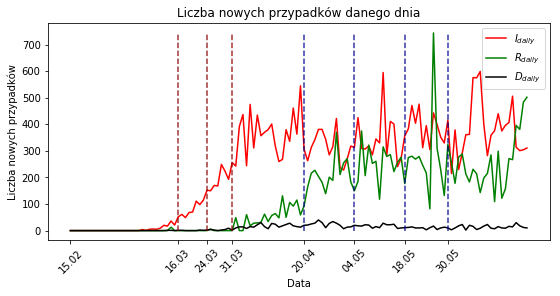

In [35]:
plt.figure(figsize=(9,4))
plt.plot(Idaily, 'r', label=r'$I_{daily}$')
plt.plot(Rdaily, 'g', label=r'$R_{daily}$')
plt.plot(Ddaily, 'k', label=r'$D_{daily}$')

mx = np.ceil(np.max(Rdaily))
plt.plot([r0,r0],[0,mx], '--', c='darkred', alpha=0.8)
plt.plot([r1,r1],[0,mx], '--', c='darkred', alpha=0.8)
plt.plot([r2,r2],[0,mx], '--', c='darkred', alpha=0.8)
plt.plot([f0,f0],[0,mx], '--', c='darkblue', alpha=0.8)
plt.plot([f1,f1],[0,mx], '--', c='darkblue', alpha=0.8)
plt.plot([f2,f2],[0,mx], '--', c='darkblue', alpha=0.8)
plt.plot([f3,f3],[0,mx], '--', c='darkblue', alpha=0.8)

my_xticks = ['15.02','16.03','24.03','31.03','20.04','04.05','18.05','30.05']
x = [0,r0,r1,r2,f0,f1,f2,f3]
plt.xticks(x, my_xticks, rotation=45)

plt.title('Liczba nowych przypadków danego dnia')
plt.xlabel('Data')
plt.ylabel('Liczba nowych przypadków')
plt.legend()
plt.savefig('images/poland.png', bbox_inches='tight')

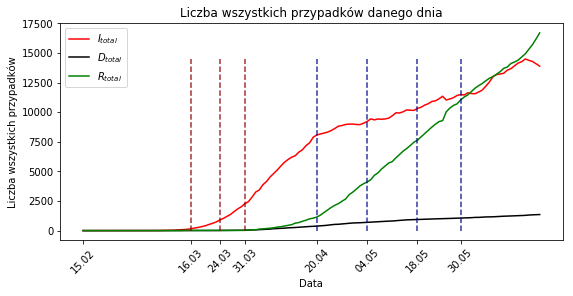

In [36]:
plt.figure(figsize=(9,4))
#np.cumsum(Idaily)-Dtotal-Rtotal
plt.plot(Itotal,'r', label=r'$I_{total}$')
plt.plot(Dtotal, 'k', label=r'$D_{total}$')
plt.plot(Rtotal, 'g', label=r'$R_{total}$')

mx = np.ceil(np.max(Itotal))
plt.plot([r0,r0],[0,mx], '--', c='darkred', alpha=0.8)
plt.plot([r1,r1],[0,mx], '--', c='darkred', alpha=0.8)
plt.plot([r2,r2],[0,mx], '--', c='darkred', alpha=0.8)
plt.plot([f0,f0],[0,mx], '--', c='darkblue', alpha=0.8)
plt.plot([f1,f1],[0,mx], '--', c='darkblue', alpha=0.8)
plt.plot([f2,f2],[0,mx], '--', c='darkblue', alpha=0.8)
plt.plot([f3,f3],[0,mx], '--', c='darkblue', alpha=0.8)

my_xticks = ['15.02','16.03','24.03','31.03','20.04','04.05','18.05','30.05']
x = [0,r0,r1,r2,f0,f1,f2,f3]
plt.xticks(x, my_xticks, rotation=45)

plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Data')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/poland_total.png', bbox_inches='tight')

## Poland
### 1st period 

R2 : 0.8478941657459403
MSE : 10.634563905113831
chi: 27.093377223567852 v: 27
pval: 0.45876546122549783
chi2: 35.436719490304505 pval: 0.1281446535566948
Param : [0.01957554 0.25311105]
Std Err param : [0.0194541  0.03608641]
dI1 :  30.166915256897422 +- 43.53668086102919


/home/marek/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


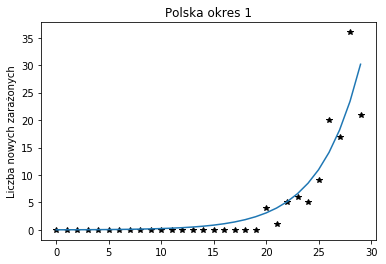

In [37]:
y = Idaily[:r0]
x = np.arange(0,r0)

p0=[1, 4000, 3000]
pe, param_cov_e = curve_fit(my_exp, x, y) 
pg, param_cov_g = curve_fit(my_gauss, x, y, p0=p0)
ps0=[0.15,45,500]
ps, param_cov_g = curve_fit(my_sigmoid, x, y, p0=ps0)

plt.plot(x,y,'k*')
plt.plot(x,my_exp(x,pe))
#plt.plot(x,my_sigmoid(x,ps))
#plt.plot(x,my_gauss(x,pg))

chi, pval = chisquare(y, my_exp(x,pe), len(pe))
R2 = r2_score(y, my_exp(x,pe))
MSE = mse(y, my_exp(x,pe))
print('R2 :', R2)
print('MSE :', MSE)
dof = len(x)-len(pe)-1
print('chi:', chi, 'v:', dof)
print('pval:',pval)

y1 = y.copy()
y1[y1==0] = 1
chi_2 = np.sum((y1 - my_exp(x,pe))**2/y1)
print('chi2:',chi_2,'pval:', 1 - chi2.cdf(chi_2,len(x)-len(pe)-1))

plt.title('Polska okres 1')
plt.ylabel('Liczba nowych zarażonych')
plt.savefig('images/poland_1.png', bbox_inches='tight')
dI1=int(my_exp(x[-1],pe))

def exp_error(x, pe, dpe):
    a, b = pe
    da, db = dpe
    err = np.sqrt( (np.exp(b*x)*da)**2 + (a*np.exp(b*x)*x*db)**2)
    return err

param_error = np.sqrt(np.diag(param_cov_e))
print('Param :', pe)
print('Std Err param :', param_error)
xx = x[-1]
print('dI1 : ',my_exp(xx,pe),'+-',exp_error(xx, pe, param_error))
eI1 = exp_error(xx, pe, param_error)

### 2st period 

R2 : 0.9575701401483238
chi: 83.9644837981535 v: 35
pval: 6.642678872743638e-06
chi2: 174.10505342892606 pval: 0.0
param : [0.22779842 0.17054823]
Std Err param : [0.08109864 0.01026968]
dI2 :  125 +- 65.26173521121345
param : [0.22779842 0.17054823]
Std Err param : [0.08109864 0.01026968]
dI1 :  32.02780505071541 +- 14.865891484072096


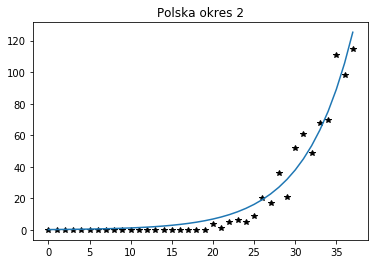

In [38]:
y = Idaily[r0:r1]
x = np.arange(0,r1-r0)
y1 = Idaily[0:r1]
x1 = np.arange(0,r1)

#p0 = [1, 4000, 3000]
pe, param_cov_e = curve_fit(my_exp, x, y) 
pe1, param_cov_e1 = curve_fit(my_exp, x1, y1) 
#pg, param_cov_g = curve_fit(my_gauss, x, y, p0=p0)

plt.plot(x1,y1,'k*')
plt.plot(x1,my_exp(x1,pe1))
#plt.plot(x+r0,my_exp(x,pe))

chi, pval = chisquare(y1, my_exp(x1,pe1), len(pe1))
R2 = r2_score(y1, my_exp(x1,pe1))
print('R2 :', R2)
print('chi:', chi, 'v:', len(x1)-len(pe1)-1)
print('pval:',pval)

y11 = y1.copy()
y11[y11==0] = 1
chi_2 = np.sum((y11 - my_exp(x1,pe1))**2/y11)
print('chi2:',chi_2,'pval:', 1 - chi2.cdf(chi_2,len(x1)-len(pe1)-1))

plt.title('Polska okres 2')
plt.ylabel('')
plt.savefig('images/poland_2.png', bbox_inches='tight')
dI2=int(my_exp(x1[-1],pe1))

param_error1 = np.sqrt(np.diag(param_cov_e1))
print('param :', pe1)
print('Std Err param :', param_error1)
print('dI2 : ',dI2,'+-',exp_error(x1[-1], pe1, param_error1))
eI2 = exp_error(x1[-1], pe1, param_error1)

param_error1 = np.sqrt(np.diag(param_cov_e1))
print('param :', pe1)
print('Std Err param :', param_error1)
print('dI1 : ',my_exp(x1[29],pe1),'+-',exp_error(x1[29], pe1, param_error1))
dI1=int(my_exp(x1[29],pe1))
eI1 = exp_error(x1[29], pe1, param_error1)

### 3rd period 

R2 : 0.9751346478791352
chi: 68.447307173041 v: 41
pval: 0.0045665450400928604
param : [2.39523262e-01 3.75434953e+01 2.69676708e+02]
Std Err param : [ 0.02559527  0.98641337 25.49313444]
dI3 :  222 +- 23.841066898780227


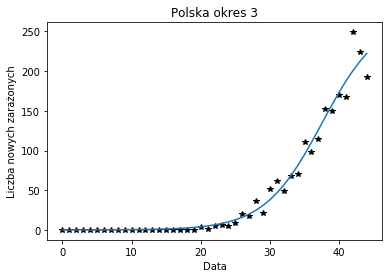

In [39]:
y = Idaily[0:r2]
x = np.arange(0,r2)

ps0=[0.15,45,500]
pg0=[500, 2000, 300]
pe, param_cov_e = curve_fit(my_exp, x, y) 
#pg, param_cov_g = curve_fit(my_gauss, x, y, p0=pg0, maxfev=2000)
ps, param_cov_s = curve_fit(my_sigmoid, x, y, p0=ps0)

plt.plot(x,y,'k*')
#plt.plot(x,my_exp(x,pe))
#plt.plot(x,my_gauss(x,pg))
plt.plot(x,my_sigmoid(x,ps))

chi, pval = chisquare(y, my_sigmoid(x,ps), len(ps))
R2 = r2_score(y, my_sigmoid(x,ps))
print('R2 :', R2)
print('chi:', chi, 'v:', len(x)-len(ps)-1)
print('pval:',pval)

plt.title('Polska okres 3')
plt.xlabel('Data')
plt.ylabel('Liczba nowych zarażonych')
plt.savefig('images/poland_3.png', bbox_inches='tight')
dI3=int(my_sigmoid(x[-1],ps))

def sig_error(x, pe, dpe):
    a, b, c = pe
    da, db, dc = dpe
    ps1 = ps.copy()
    ps1[2] = 1
    err = np.sqrt((my_sigmoid(x,ps)*my_sigmoid(x,ps1)*np.exp(-a*(x-b))*(b-x)*da)**2+
                  (my_sigmoid(x,ps)*my_sigmoid(x,ps1)*np.exp(-a*(x-b))*a*db)**2+
                  (my_sigmoid(x,ps1)*dc)**2 )
    return err

param_error = np.sqrt(np.diag(param_cov_s))
print('param :', ps)
print('Std Err param :', param_error)
print('dI3 : ',dI3,'+-',sig_error(x[-1], ps, param_error))
eI3 = sig_error(x[-1], ps, param_error)

### 4th period 

R2 : 0.9247608464359028


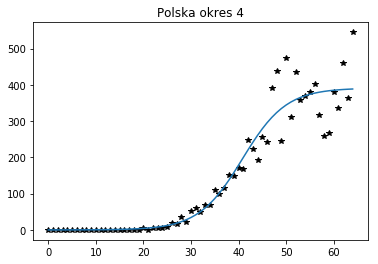

param : [2.17082686e-01 4.08036446e+01 3.91029864e+02]
Std Err param : [ 0.02559527  0.98641337 25.49313444]
dI4 :  64 +- 25.37792459663654


In [40]:
y = Idaily[0:f0]
x = np.arange(0,f0)

ps0=[0.15,45,500]
pg0=[500, 2000, 300]
pe, param_cov_e = curve_fit(my_exp, x, y) 
#pg, param_cov_g = curve_fit(my_gauss, x, y, p0=pg0, maxfev=2000)
ps, param_cov_g = curve_fit(my_sigmoid, x, y, p0=ps0)

plt.plot(x,y,'k*')
#plt.plot(x,my_exp(x,pe))
#plt.plot(x,my_gauss(x,pg))
plt.plot(x,my_sigmoid(x,ps))

chi, pval = chisquare(y, my_sigmoid(x,ps),len(ps))
R2 = r2_score(y, my_sigmoid(x,ps))
print('R2 :', R2)

plt.title('Polska okres 4')
plt.show()

param_error = np.sqrt(np.diag(param_cov_s))
print('param :', ps)
print('Std Err param :', param_error)
print('dI4 : ',x[-1], '+-',sig_error(x[-1], ps, param_error))

R2 : 0.8789027715105414
chi: 1130.5239899866883 v: 101 pval: 0.0
pval: 1.4236886742361208e-173
param : [2.55050671e-01 3.97146602e+01 3.56138294e+02]
Std Err param : [0.04839111 0.85521995 8.36830255]
dI4 :  356 +- 8.368301913302371


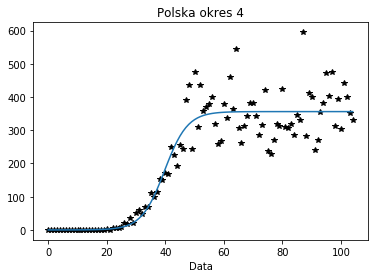

In [41]:
y = Idaily[0:f3]
x = np.arange(0,f3)

ps0=[0.15,45,500]
pg0=[500, 2000, 300]
pe, param_cov_e = curve_fit(my_exp, x, y) 
#pg, param_cov_g = curve_fit(my_gauss, x, y, p0=pg0, maxfev=2000)
ps, param_cov_s = curve_fit(my_sigmoid, x, y, p0=ps0)

plt.plot(x,y,'k*')
#plt.plot(x,my_exp(x,pe))
#plt.plot(x,my_gauss(x,pg))
plt.plot(x,my_sigmoid(x,ps))

chi, pval = chisquare(y, my_sigmoid(x,ps),len(ps))
R2 = r2_score(y, my_sigmoid(x,ps))
#chi = np.sum((y - my_sigmoid(x,ps))**2)
print('R2 :', R2)
print('chi:', chi, 'v:', len(x)-len(ps)-1, 'pval:', 1 - chi2.cdf(chi,len(x)-len(ps)-1))
print('pval:',pval)


plt.title('Polska okres 4')
plt.xlabel('Data')
plt.ylabel('')
plt.savefig('images/poland_4.png', bbox_inches='tight')
dI4=int(my_sigmoid(x[-1],ps))

param_error = np.sqrt(np.diag(param_cov_s))
print('param :', ps)
print('Std Err param :', param_error)
print('dI4 : ',dI4, '+-',sig_error(x[-1], ps, param_error))
eI4 = sig_error(x[-1], ps, param_error)

R2 : 0.7968408782420046
chi: 1122.2102054583086 v: 81
chi2: 1045.7778565980611 pval: 0.0
pval: 6.680029760307057e-183


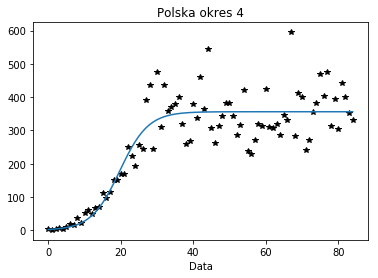

param : [2.54931791e-01 1.97142277e+01 3.56142754e+02]
Std Err param : [0.05402349 0.95395104 9.33402762]
dI4 :  356 +- 9.334026904452942


In [42]:
y = Idaily[20:f3]
x = np.arange(0,f3-20)

ps0=[0.15,45,500]
pg0=[500, 2000, 300]
pe, param_cov_e = curve_fit(my_exp, x, y) 
#pg, param_cov_g = curve_fit(my_gauss, x, y, p0=pg0, maxfev=2000)
ps, param_cov_s = curve_fit(my_sigmoid, x, y, p0=ps0)

plt.plot(x,y,'k*')
#plt.plot(x,my_exp(x,pe))
#plt.plot(x,my_gauss(x,pg))
plt.plot(x,my_sigmoid(x,ps))

chi, pval = chisquare(y, my_sigmoid(x,ps),len(ps))
R2 = r2_score(y, my_sigmoid(x,ps))
chi_2 = np.sum((y - my_sigmoid(x,ps))**2/y)
print('R2 :', R2)
print('chi:', chi, 'v:', len(x)-len(ps)-1) 
print('chi2:',chi_2,'pval:', 1 - chi2.cdf(chi_2,len(x)-len(ps)-1))
print('pval:',pval)


plt.title('Polska okres 4')
plt.xlabel('Data')
plt.ylabel('')
#plt.savefig('images/poland_4.png', bbox_inches='tight')
plt.show()
dI4=int(my_sigmoid(x[-1],ps))

param_error = np.sqrt(np.diag(param_cov_s))
print('param :', ps)
print('Std Err param :', param_error)
print('dI4 : ',dI4, '+-',sig_error(x[-1], ps, param_error))
eI4 = sig_error(x[-1], ps, param_error)

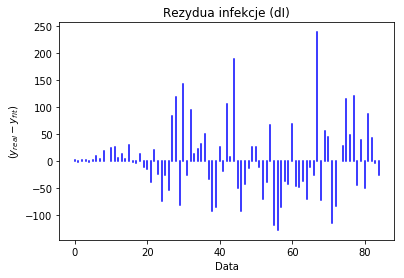

In [43]:
for i in range(len(y)):
    yi = my_sigmoid(i,ps)
    plt.plot([i,i],[0,y[i]-yi],c='b')
plt.title('Rezydua infekcje (dI)')
plt.xlabel('Data')
plt.ylabel(r'($y_{real}-y_{fit}$)')
plt.show()

R2 : 0.7662632718863621
chi: 2233.211673626 v: 101 pval: 0.0
chi2: inf pval: 0.0
param : [1.68177366e-01 6.44675988e+01 2.67319860e+02]
Std Err param : [ 0.04115165  1.72345526 14.72553093]
dR1 :  0 +- 1.1693182690533055
dR2 :  3 +- 3.437908827317228
dR3 :  9 +- 8.021606797285537
dR4 :  266 +- 14.717552249629257


/home/marek/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/home/marek/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


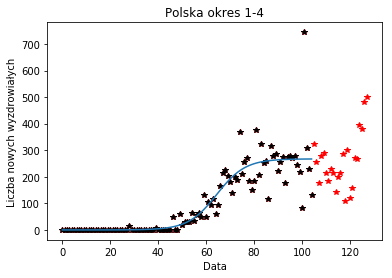

In [51]:
y = Rdaily[:f3]
x = np.arange(0,f3)

pe, param_cov_e = curve_fit(my_exp, x, y) 
pg, param_cov_g = curve_fit(my_gauss, x, y, p0=p0)
ps, param_cov_s = curve_fit(my_sigmoid, x, y, p0=ps0)

plt.plot(Rdaily,'r*')
plt.plot(x,y,'k*')
#plt.plot(x,my_exp(x,pe))
#plt.plot(x,my_gauss(x,pg))
plt.plot(x,my_sigmoid(x,ps))

dR1=int(my_sigmoid(x[r0],ps))
dR2=int(my_sigmoid(x[r1],ps))
dR3=int(my_sigmoid(x[r2],ps))
dR4=int(my_sigmoid(x[-1],ps))

chi, pval = chisquare(y, my_sigmoid(x,ps), len(ps))
R2 = r2_score(y, my_sigmoid(x,ps))
chi_2 = np.sum((y - my_sigmoid(x,ps))**2/y)
print('R2 :', R2)
print('chi:', chi, 'v:', len(x)-len(ps)-1, 'pval:', pval)
print('chi2:',chi_2,'pval:', 1 - chi2.cdf(chi_2,len(x)-len(ps)-1))

def gauss_error(x, pe, dpe):
    a, m, s = pe
    da, dm, ds = dpe
    err = np.sqrt((my_gauss(x,pe)*da)**2+
                 (my_gauss(x,pe)*(x-m)/s/s*dm)**2+
                 (my_gauss(x,pe)*(x-m)**2/s/s/s*ds)**2)
    return err

plt.title('Polska okres 1-4')
plt.xlabel('Data')
plt.ylabel('Liczba nowych wyzdrowiałych')
plt.savefig('images/poland_R.png', bbox_inches='tight')


param_error = np.sqrt(np.diag(param_cov_s))
print('param :', ps)
print('Std Err param :', param_error)
print('dR1 : ',dR1, '+-',sig_error(x[r0], ps, param_error))
print('dR2 : ',dR2, '+-',sig_error(x[r1], ps, param_error))
print('dR3 : ',dR3, '+-',sig_error(x[r2], ps, param_error))
print('dR4 : ',dR4, '+-',sig_error(x[-1], ps, param_error))
eR1 = sig_error(x[r0], ps, param_error)
eR2 = sig_error(x[r1], ps, param_error)
eR3 = sig_error(x[r2], ps, param_error)
eR4 = sig_error(x[-1], ps, param_error)

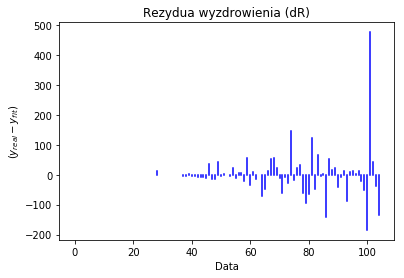

In [45]:
for i in range(len(y)):
    yi = my_sigmoid(i,ps)
    plt.plot([i,i],[0,y[i]-yi],c='b')
plt.title('Rezydua wyzdrowienia (dR)')
plt.xlabel('Data')
plt.ylabel(r'($y_{real}-y_{fit}$)')
plt.show()

R2 : 0.7554813874195958
chi: 1857.6139258843036 v: 100
pval: 0.0
Std Err param : [1.10633452e-05 2.31969050e-03 1.60198004e-01 4.06877059e+00
 3.02311477e+01]
30
[  8.96130959  62.63164356 144.17820334 122.06311755  30.23114774]
dR1 :  -7 +- 201.50362062060395
38
[ 23.0685793  127.28605723 231.32591736 154.61328223  30.23114774]
dR2 :  0 +- 308.32575159382816
45
[ 45.36662979 211.381797   324.40095752 183.09467633  30.23114774]
dR3 :  18 +- 431.7568288234943
104
[1294.25490498 2609.33633695 1732.70160816  423.15214085   30.23114774]
dR4 :  244 +- 3415.5465738179128


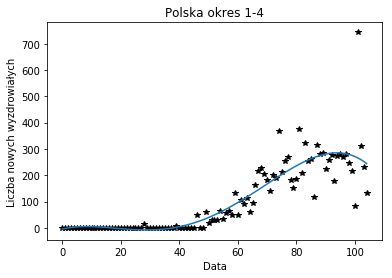

In [46]:
rk_p = 4
coef_p, cov_p = np.polyfit(x, y, rk_p, cov=True)

def poly_error(x, pe, dpe):
    arr_pow = np.power(np.repeat(x,len(dpe)), np.arange(len(dpe),0,-1)-1) 
    print(x)
    print(np.sqrt((dpe*arr_pow)**2))
    err = np.sqrt(np.sum((dpe*arr_pow)**2))
    return err

y_found = np.polyval(coef_p, x)

dR1=int(y_found[r0])
dR2=int(y_found[r1])
dR3=int(y_found[r2])
dR4=int(y_found[-1])

param_error = np.sqrt(np.diag(cov_p))
chi, pval = chisquare(y, y_found, rk_p)
R2 = r2_score(y, y_found)
print('R2 :', R2)
print('chi:', chi, 'v:', len(x)-rk_p-1)
print('pval:', pval)
print('Std Err param :', param_error)

print('dR1 : ',dR1, '+-',poly_error(x[r0], coef_p, param_error))
print('dR2 : ',dR2, '+-',poly_error(x[r1], coef_p, param_error))
print('dR3 : ',dR3, '+-',poly_error(x[r2], coef_p, param_error))
print('dR4 : ',dR4, '+-',poly_error(x[-1], coef_p, param_error))

plt.plot(y, 'k*')
plt.plot(y_found)
plt.title('Polska okres 1-4')
plt.xlabel('Data')
plt.ylabel('Liczba nowych wyzdrowiałych')
plt.savefig('images/poland_R_poly.png', bbox_inches='tight')

/home/marek/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


R2 : 0.7209593757234275
chi: 399.1260747180749 v: 101 pval: 4.733738909151545e-37
chi2: 358.22523117996985 pval: 0.0
param : [289.97854144  71.67903515  19.35223793]
Std Err param : [11.24760812  1.09902011  1.18355121]
dD1 :  2 +- 25.790067087230895
dD2 :  5 +- 57.66552922724535
dD3 :  9 +- 101.35643929912138
dD4 :  5 +- 64.99450892768347


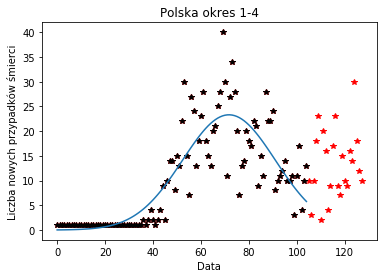

In [52]:
y = Ddaily[:f3]
x = np.arange(0,f3)

pe, param_cov_e = curve_fit(my_exp, x, y) 
pg, param_cov_g = curve_fit(my_gauss, x, y, p0=p0)
ps, param_cov_s = curve_fit(my_sigmoid, x, y, p0=ps0)

plt.plot(Ddaily,'r*')
plt.plot(x,y,'k*')
#plt.plot(x,my_exp(x,pe))
plt.plot(x,my_gauss(x,pg))
#plt.plot(x,my_sigmoid(x,ps))

y[y<1] = 1

chi, pval = chisquare(y, my_gauss(x,pg), len(pg))
R2 = r2_score(y, my_gauss(x,pg))
chi_2 = np.sum((y - my_sigmoid(x,ps))**2/y)

print('R2 :', R2)
print('chi:', chi, 'v:', len(x)-len(pg)-1, 'pval:', pval)
print('chi2:',chi_2,'pval:', 1 - chi2.cdf(chi_2,len(x)-len(ps)-1))

plt.title('Polska okres 1-4')
plt.xlabel('Data')
plt.ylabel('Liczba nowych przypadków śmierci')
plt.savefig('images/poland_D.png', bbox_inches='tight')
dD1=int(my_gauss(x[r0],pg))
dD2=int(my_gauss(x[r1],pg))
dD3=int(my_gauss(x[r2],pg))
dD4=int(my_gauss(x[-1],pg))

param_error = np.sqrt(np.diag(param_cov_g))
print('param :', pg)
print('Std Err param :', param_error)
print('dD1 : ',dD1, '+-',gauss_error(x[r0], pg, param_error))
print('dD2 : ',dD2, '+-',gauss_error(x[r1], pg, param_error))
print('dD3 : ',dD3, '+-',gauss_error(x[r2], pg, param_error))
print('dD4 : ',dD4, '+-',gauss_error(x[-1], pg, param_error))
eD1 = gauss_error(x[r0], pg, param_error)
eD2 = gauss_error(x[r1], pg, param_error)
eD3 = gauss_error(x[r2], pg, param_error)
eD4 = gauss_error(x[-1], pg, param_error)

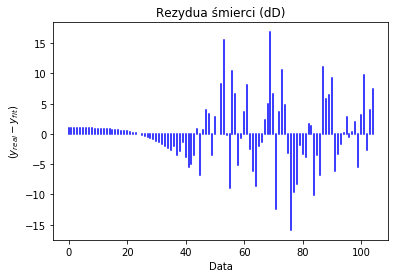

In [48]:
for i in range(len(y)):
    yi = my_gauss(i,pg)
    plt.plot([i,i],[0,y[i]-yi],c='b')
plt.title('Rezydua śmierci (dD)')
plt.xlabel('Data')
plt.ylabel(r'($y_{real}-y_{fit}$)')
plt.show()

R2 : 0.7438610921691021
chi: 214.9215475738432 v: 97
pval: 1.0150831982080573e-09
Std Err param : [4.79944073e-11 1.75153627e-08 2.54270690e-06 1.86765627e-04
 7.29137897e-03 1.44927912e-01 1.26541148e+00 3.50210172e+00]


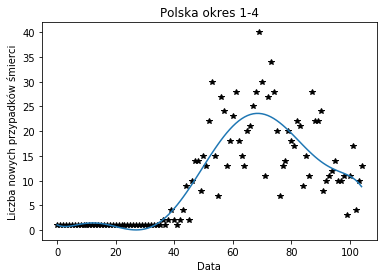

In [49]:
rk_p = 7
coef_p, cov_p = np.polyfit(x, y, rk_p, cov=True)
## coefficients
## residuals
##rank
## singular values
## conditioning threshold
y_found = np.polyval(coef_p, x)

param_error = np.sqrt(np.diag(cov_p))
chi, pval = chisquare(y, y_found)
R2 = r2_score(y, y_found)
print('R2 :', R2)
print('chi:', chi, 'v:', len(x)-rk_p-1)
print('pval:', pval)
print('Std Err param :', param_error)

plt.plot(y, 'k*')
plt.plot(y_found)

plt.title('Polska okres 1-4')
plt.xlabel('Data')
plt.ylabel('Liczba nowych przypadków śmierci')
plt.savefig('images/poland_D_poly.png', bbox_inches='tight')

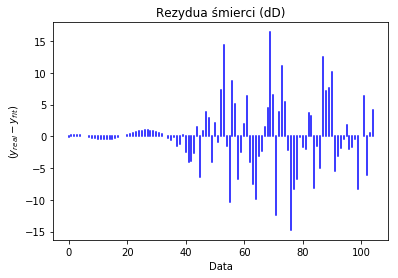

In [50]:
for i in range(len(y)):
    yi = y_found[i]
    plt.plot([i,i],[0,y[i]-yi],c='b')
plt.title('Rezydua śmierci (dD)')
plt.xlabel('Data')
plt.ylabel(r'($y_{real}-y_{fit}$)')
plt.show()

### Computed Values

In [53]:
print(dI1,dI2,dI3,dI4)
print(dR1,dR2,dR3,dR4)
print(dD1,dD2,dD3,dD4)

32 125 222 356
0 3 9 266
2 5 9 5


In [54]:
print(eI1,eI2,eI3,eI4)
print(eR1,eR2,eR3,eR4)
print(eD1,eD2,eD3,eD4)

14.865891484072096 65.26173521121345 23.841066898780227 9.334026904452942
1.1693182690533055 3.437908827317228 8.021606797285537 14.717552249629257
25.790067087230895 57.66552922724535 101.35643929912138 64.99450892768347


In [55]:
print(Itotal[[r0-5,r1-5,r2-5,f3-5]])
print(Rtotal[[r0-15,r1-15,r2-15,f3-15]])
print(Dtotal[[r0-15,r1-15,r2-15,f3-15]])

[   31.   337.  1198. 11348.]
[   0.    0.   13. 6930.]
[  0.   0.   4. 907.]


In [56]:
I_15 = Itotal[[r0-15,r1-15,r2-15,f3-15]]
I_15[I_15==0]=1
print(np.array([eR1,eR2,eR3,eR4])/I_15)
print(np.array([eD1,eD2,eD3,eD4])/I_15)
gm = np.array([eR1,eR2,eR3,eR4])/I_15
bt = np.array([eD1,eD2,eD3,eD4])/I_15

[1.16931827 0.20222993 0.05013504 0.00144417]
[2.57900671e+01 3.39208995e+00 6.33477746e-01 6.37763801e-03]


In [57]:
print(np.sqrt((np.array([eI1,eI2,eI3,eI4])/I_15)**2+
             (gm)**2+(bt)**2))

[2.97907636e+01 5.12684318e+00 6.52694847e-01 6.60293775e-03]


### Calculation od model

Iitialize parameters

In [58]:
# Total population, N.
N = 37 * 10**6

Function to count derivatives <br>
credit: https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

In [59]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma, delta):
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I - delta * I
    dRdt = gamma * I
    dDdt = delta * I
    return dSdt, dIdt, dRdt, dDdt

parameter estimation: https://www.hindawi.com/journals/ddns/2018/3187807/ <br>
https://www.statsandr.com/blog/covid-19-in-belgium/

In [129]:
def plot_SIR(I0,R0,D0, dI,dR,dD, tit,t_max=200):
    # Initial number of infected and recovered individuals, I0, R0, D0.
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0 - D0
    # parameters
    gamma = dR/I0
    delta = dD/I0
    beta = (dI + (gamma-delta)*I0)*N/(S0*I0)
    print('beta =',beta,'beta_2 =',dI/S0/I0)
    print('gamma =',gamma)
    print('delta =',delta)
    
    # A grid of time points (in days)
    t = np.linspace(0, t_max, t_max)
    
    # Initial conditions vector
    y0 = S0, I0, R0, D0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta))
    S, I, R, D = ret.T
    
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure()
    plt.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='S')
    plt.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='I')
    plt.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='R')
    plt.plot(t, D/1000, 'k', alpha=0.5, lw=2, label='D')
    
    plt.xlabel('Dzień')
    plt.ylabel('Liczba przypadków (tysiące)')
    legend = plt.legend()
    legend.get_frame().set_alpha(0.5)
    plt.title(tit)    
    return S, I, R, D

def compute_SIRD(I0,R0,D0, beta, gamma, delta, t_max=200):
    # Initial number of infected and recovered individuals, I0, R0, D0.
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0 - D0
    # parameters
    #print('beta =',beta)
    #print('gamma =',gamma)
    #print('delta =',delta)
    
    # A grid of time points (in days)
    t = np.linspace(0, t_max, t_max)
    
    # Initial conditions vector
    y0 = S0, I0, R0, D0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta))
    S, I, R, D = ret.T
       
    return I

Plotting results

beta = 0.9677427462953611 beta_2 = 2.789888998328969e-08
gamma = 0.0
delta = 0.06451612903225806
beta = 0.3649884875593507 beta_2 = 1.0024952965264521e-08
gamma = 0.008902077151335312
delta = 0.01483679525222552
beta = 0.1853149334218662 beta_2 = 5.008511714104492e-09
gamma = 0.007512520868113523
delta = 0.007512520868113523
beta = 0.05439902086783666 beta_2 = 8.483092307569254e-10
gamma = 0.02344025378921396
delta = 0.0004406062742333451
[1.16931827 0.20222993 0.05013504 0.00144417]
[2.57900671e+01 3.39208995e+00 6.33477746e-01 6.37763801e-03]


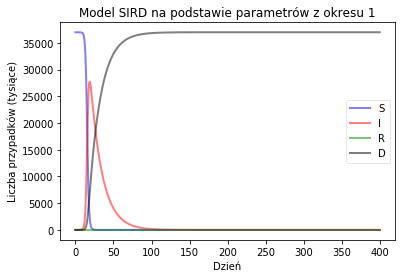

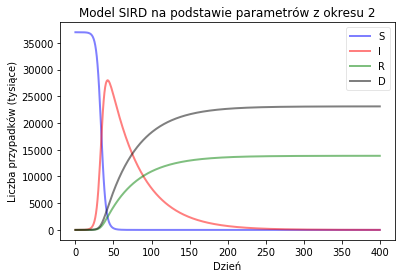

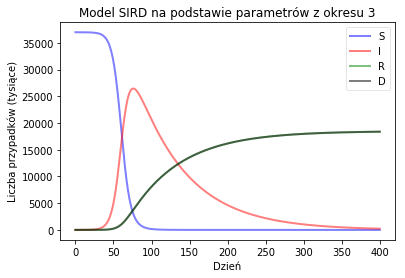

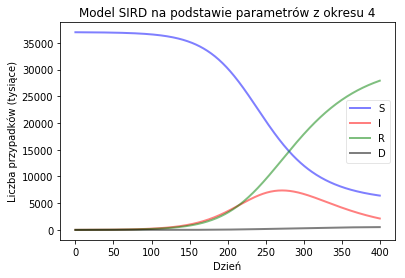

In [61]:
Itab = []
for i, nt in enumerate([r0,r1,r2,f3]):
    dValuse = [[dI1,dR1,dD1],
              [dI2,dR2,dD2],
              [dI3,dR3,dD3],
              [dI4,dR4,dD4]]
    S, I, R, D  = plot_SIR(Itotal[nt-5],Rtotal[nt-15],Dtotal[nt-15], 
                           dValuse[i][0],dValuse[i][1],dValuse[i][2],
                           tit='Model SIRD na podstawie parametrów z okresu '+str(i+1),
                           t_max=400)
    Itab.append(I)
    
    plt.savefig('images/poland_SIRD'+str(i+1)+'.png', bbox_inches='tight')

print(np.array([eR1,eR2,eR3,eR4])/I_15)
print(np.array([eD1,eD2,eD3,eD4])/I_15)

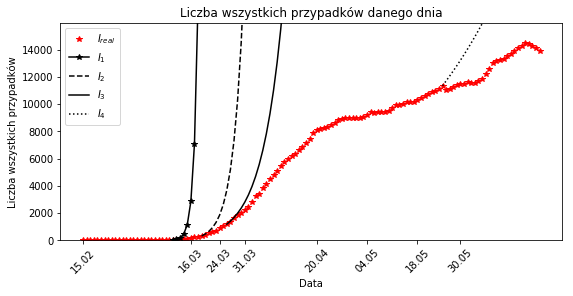

In [86]:
plt.figure(figsize=(9,4))
#np.cumsum(Idaily)-Dtotal-Rtotal
plt.plot(Itotal,'r*', label=r'$I_{real}$')
plt.plot(np.arange(r0-5,len(Itotal)),Itab[0][:len(Itotal)-r0+5],'k-*', label=r'$I_{1}$')
plt.plot(np.arange(r1-5,len(Itotal)),Itab[1][:len(Itotal)-r1+5],'k--', label=r'$I_{2}$')
plt.plot(np.arange(r2-5,len(Itotal)),Itab[2][:len(Itotal)-r2+5],'k-', label=r'$I_{3}$')
plt.plot(np.arange(f3-5,len(Itotal)),Itab[3][:len(Itotal)-f3+5],'k:', label=r'$I_{4}$')

my_xticks = ['15.02','16.03','24.03','31.03','20.04','04.05','18.05','30.05']
x = [0,r0,r1,r2,f0,f1,f2,f3]
plt.xticks(x, my_xticks, rotation=45)

plt.ylim(0,1.1*np.max(Itotal))
plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Data')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/poland_compare.png', bbox_inches='tight')

In [140]:
beta0 = 0.9677427462953611 
gamma0 = 0.0
delta0 = 0.06451612903225806
beta1 = 0.3649884875593507 
gamma1 = 0.008902077151335312
delta1 = 0.01483679525222552
beta2 = 0.1853149334218662 
gamma2 = 0.007512520868113523
delta2 = 0.007512520868113523
beta3 = 0.05439902086783666
gamma3 = 0.02344025378921396
delta3 = 0.0004406062742333451

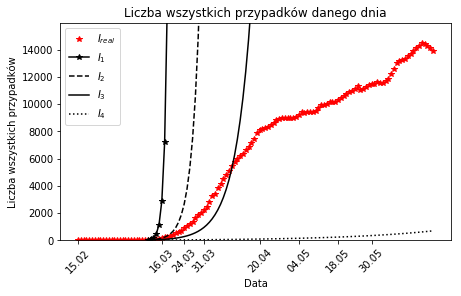

In [141]:
plt.figure(figsize=(7,4))

rt = r0

I_r0 = compute_SIRD(Itotal[rt-5],Rtotal[rt-15],Dtotal[rt-15], beta0, gamma0, delta0, t_max=200)
I_r1 = compute_SIRD(Itotal[rt-5],Rtotal[rt-15],Dtotal[rt-15], beta1, gamma1, delta1, t_max=200)
I_r2 = compute_SIRD(Itotal[rt-5],Rtotal[rt-15],Dtotal[rt-15], beta2, gamma2, delta2, t_max=200)
I_f3 = compute_SIRD(Itotal[rt-5],Rtotal[rt-15],Dtotal[rt-15], beta3, gamma3, delta3, t_max=200)

plt.ylim(0,1.1*np.max(Itotal))

plt.plot(Itotal,'r*', label=r'$I_{real}$')
plt.plot(np.arange(rt-5,len(Itotal)),I_r0[:len(Itotal)-rt+5],'k*-', label=r'$I_{1}$')
plt.plot(np.arange(rt-5,len(Itotal)),I_r1[:len(Itotal)-rt+5],'k--', label=r'$I_{2}$')
plt.plot(np.arange(rt-5,len(Itotal)),I_r2[:len(Itotal)-rt+5],'k-', label=r'$I_{3}$')
plt.plot(np.arange(rt-5,len(Itotal)),I_f3[:len(Itotal)-rt+5],'k:', label=r'$I_{4}$')

my_xticks = ['15.02','16.03','24.03','31.03','20.04','04.05','18.05','30.05']
x = [0,r0,r1,r2,f0,f1,f2,f3]
plt.xticks(x, my_xticks, rotation=45)

plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Data')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/poland_compare_r0.png', bbox_inches='tight')

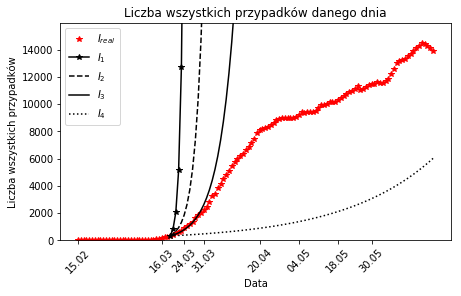

In [142]:
plt.figure(figsize=(7,4))

rt = r1

I_r0 = compute_SIRD(Itotal[rt-5],Rtotal[rt-15],Dtotal[rt-15], beta0, gamma0, delta0, t_max=200)
I_r1 = compute_SIRD(Itotal[rt-5],Rtotal[rt-15],Dtotal[rt-15], beta1, gamma1, delta1, t_max=200)
I_r2 = compute_SIRD(Itotal[rt-5],Rtotal[rt-15],Dtotal[rt-15], beta2, gamma2, delta2, t_max=200)
I_f3 = compute_SIRD(Itotal[rt-5],Rtotal[rt-15],Dtotal[rt-15], beta3, gamma3, delta3, t_max=200)

plt.ylim(0,1.1*np.max(Itotal))

plt.plot(Itotal,'r*', label=r'$I_{real}$')
plt.plot(np.arange(rt-5,len(Itotal)),I_r0[:len(Itotal)-rt+5],'k*-', label=r'$I_{1}$')
plt.plot(np.arange(rt-5,len(Itotal)),I_r1[:len(Itotal)-rt+5],'k--', label=r'$I_{2}$')
plt.plot(np.arange(rt-5,len(Itotal)),I_r2[:len(Itotal)-rt+5],'k-', label=r'$I_{3}$')
plt.plot(np.arange(rt-5,len(Itotal)),I_f3[:len(Itotal)-rt+5],'k:', label=r'$I_{4}$')

my_xticks = ['15.02','16.03','24.03','31.03','20.04','04.05','18.05','30.05']
x = [0,r0,r1,r2,f0,f1,f2,f3]
plt.xticks(x, my_xticks, rotation=45)

plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Data')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/poland_compare_r1.png', bbox_inches='tight')

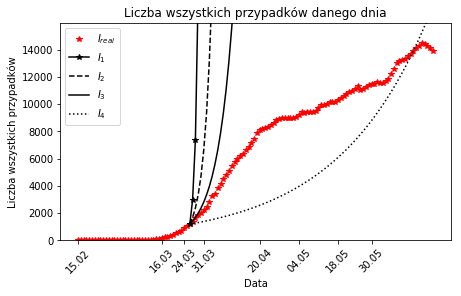

In [143]:
plt.figure(figsize=(7,4))

rt = r2

I_r0 = compute_SIRD(Itotal[rt-5],Rtotal[rt-15],Dtotal[rt-15], beta0, gamma0, delta0, t_max=200)
I_r1 = compute_SIRD(Itotal[rt-5],Rtotal[rt-15],Dtotal[rt-15], beta1, gamma1, delta1, t_max=200)
I_r2 = compute_SIRD(Itotal[rt-5],Rtotal[rt-15],Dtotal[rt-15], beta2, gamma2, delta2, t_max=200)
I_f3 = compute_SIRD(Itotal[rt-5],Rtotal[rt-15],Dtotal[rt-15], beta3, gamma3, delta3, t_max=200)

plt.ylim(0,1.1*np.max(Itotal))

plt.plot(Itotal,'r*', label=r'$I_{real}$')
plt.plot(np.arange(rt-5,len(Itotal)),I_r0[:len(Itotal)-rt+5],'k*-', label=r'$I_{1}$')
plt.plot(np.arange(rt-5,len(Itotal)),I_r1[:len(Itotal)-rt+5],'k--', label=r'$I_{2}$')
plt.plot(np.arange(rt-5,len(Itotal)),I_r2[:len(Itotal)-rt+5],'k-', label=r'$I_{3}$')
plt.plot(np.arange(rt-5,len(Itotal)),I_f3[:len(Itotal)-rt+5],'k:', label=r'$I_{4}$')

my_xticks = ['15.02','16.03','24.03','31.03','20.04','04.05','18.05','30.05']
x = [0,r0,r1,r2,f0,f1,f2,f3]
plt.xticks(x, my_xticks, rotation=45)

plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Data')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/poland_compare_r2.png', bbox_inches='tight')

# SIR model

In [155]:
# The SIR model differential equations.
def deriv2(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [230]:
def SIR(I0,R0,N, dI,dR,t_max=200):
    # Initial number of infected and recovered individuals, I0, R0, D0.
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0 
    # parameters
    gamma = dR/I0
    beta = (dI + gamma*I0)*N/(S0*I0)
    print('beta =',beta)
    print('gamma =',gamma)
    
    # A grid of time points (in days)
    t = np.linspace(0, t_max, t_max)
    
    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv2, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    #fig = plt.figure()
    #plt.plot(t+dt, S/1000, 'b', alpha=0.5, lw=2, label='S')
    #plt.plot(t+dt, I/1000, 'r', alpha=0.5, lw=2, label='I')
    #plt.plot(t+dt, R/1000, 'g', alpha=0.5, lw=2, label='R')
    
    #plt.xlabel('Dzień')
    #plt.ylabel('Liczba przypadków (tysiące)')
    #legend = plt.legend()
    #legend.get_frame().set_alpha(0.5)
    #plt.title(tit) 
    return S, I ,R
    
def compute_SIR(I0,R0, beta, gamma, t_max=200):
    # Initial number of infected and recovered individuals, I0, R0, D0.
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0 
    # parameters
    #print('beta =',beta)
    #print('gamma =',gamma)
    #print('delta =',delta)
    
    # A grid of time points (in days)
    t = np.linspace(0, t_max, t_max)
    
    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv2, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
       
    return I

## Malaysia

In [300]:
names, datas, dates = get_data(mal)

datas shape: (7, 128)
0 Cases
1 Cases
2 Daily Cases
3 Currently Infected
4 Deaths
5 Deaths
6 Daily Deaths


In [301]:
Itotal = datas[3]
Rtotal = np.cumsum(datas[2]) - datas[3]

Idaily = datas[2]
Rdaily = np.diff(Rtotal)
Rdaily[Rdaily<0] = 0

In [302]:
x = np.arange(0,Idaily.shape[0])

pg, param_cov_g = curve_fit(my_gauss, x, Idaily,p0=[100,60,40])
pg1, param_cov_g1 = curve_fit(my_gauss, x[:-1], Rdaily, p0=[100,60,40])

/home/marek/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


No handles with labels found to put in legend.


R2_R : 0.28664172578671454
R2_I : 0.4252659543610232
param : [ 0.44129068 45.77594652 17.73492218]
Std Err param : [104.36821467   1.31145466   1.31334178]
dR :  79.52747517405268 +- 9084.163942119723
dI :  162.38360714941845 +- 16947.68722045237


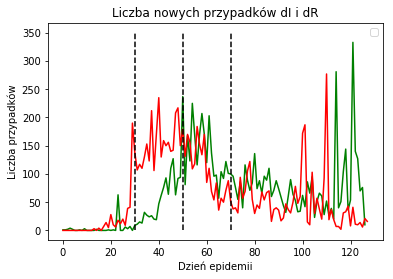

In [303]:
plt.plot(Rdaily,'g')
plt.plot(Idaily,'r')

#plt.plot(x,my_gauss(x,pg),'--',c='darkred', label=r'$I_{fit}$')
#plt.plot(x,my_gauss(x,pg1),'--',c='darkgreen', label=r'$I_{fit}$')

plt.legend()
plt.title('Liczba nowych przypadków dI i dR')
plt.xlabel('Dzień epidemii')
plt.ylabel('Liczba przypadków')
plt.plot([30,30],[0,350],'k--')
plt.plot([50,50],[0,350],'k--')
plt.plot([70,70],[0,350],'k--')


plt.savefig('images/malysian_fit.png', bbox_inches='tight')
day = 50
dR = my_gauss(x,pg1)[day]
dI = my_gauss(x,pg)[day]

R2 = r2_score(Rdaily, my_gauss(x,pg1)[:-1])
print('R2_R :', R2)

R2 = r2_score(Idaily, my_gauss(x,pg))
print('R2_I :', R2)

param_error1 = np.sqrt(np.diag(param_cov_g1))
param_error = np.sqrt(np.diag(param_cov_g))
print('param :', ps)
print('Std Err param :', param_error)
print('dR : ',dR, '+-',gauss_error(x[day], pg1, param_error1))
print('dI : ',dI, '+-',gauss_error(x[day], pg, param_error))


In [304]:
dI = np.array([np.mean(Idaily[24:27]), np.mean(Idaily[44:47]), np.mean(Idaily[64:67])])
dR = np.array([np.mean(Rdaily[14:17]), np.mean(Rdaily[34:37]), np.mean(Rdaily[54:57])])
eI = np.array([np.max(Idaily[24:27])-np.min(Idaily[24:27]), 
               np.max(Idaily[44:47])-np.min(Idaily[44:47]),  
               np.max(Idaily[64:67])-np.min(Idaily[64:67])])/2/np.sqrt(3)
eR = np.array([np.max(Rdaily[14:17])-np.min(Rdaily[14:17]), 
               np.max(Rdaily[34:37])-np.min(Rdaily[34:37]),  
               np.max(Rdaily[54:57])-np.min(Rdaily[54:57])])/2/np.sqrt(3)

In [305]:
ge = eR/Itotal[[25,45,65]]
be = np.sqrt( (eI/Itotal[[15,35,55]])**2 + ge**2 )

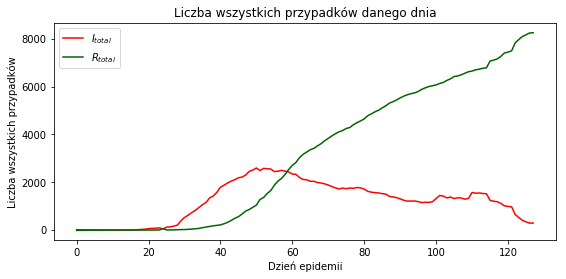

In [306]:
plt.figure(figsize=(9,4))
#np.cumsum(Idaily)-Dtotal-Rtotal
plt.plot(Itotal,'r', label=r'$I_{total}$')
plt.plot(Rtotal, 'darkgreen', label=r'$R_{total}$')

plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Dzień epidemii')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/malysia_total.png', bbox_inches='tight')

In [307]:
Itab = []
for i, nt in enumerate([30,50,70]):
    dValuse = [[dI1,dR1],
              [dI2,dR2],
              [dI3,dR3]]
    S, I, R  = SIR(Itotal[nt-5],Rtotal[nt-15], N,
                   dValuse[i][0],dValuse[i][1],
                   t_max=400)
    Itab.append(I)
print(be)
print(ge)

beta = 0.26016551074945465
gamma = 0.0
beta = 0.058566608534554705
gamma = 0.0013723696248856359
beta = 0.11322015106875999
gamma = 0.004409603135717786
[0.45365664 0.00447961 0.0164246 ]
[0.0046939  0.00105645 0.01541675]


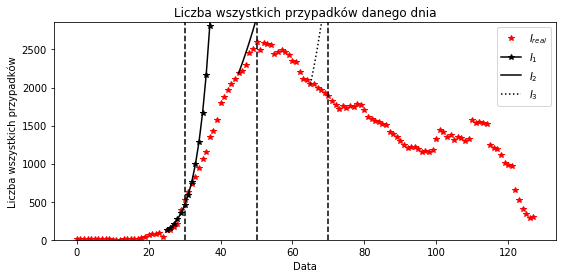

In [308]:
plt.figure(figsize=(9,4))
#np.cumsum(Idaily)-Dtotal-Rtotal
plt.plot(Itotal,'r*', label=r'$I_{real}$')
plt.plot(np.arange(25,len(Itotal)),Itab[0][:len(Itotal)-25],'k-*', label=r'$I_{1}$')
plt.plot(np.arange(45,len(Itotal)),Itab[1][:len(Itotal)-45],'k-', label=r'$I_{2}$')
plt.plot(np.arange(65,len(Itotal)),Itab[2][:len(Itotal)-65],'k:', label=r'$I_{3}$')

plt.plot([30,30],[0,1.1*np.max(Itotal)],'k--')
plt.plot([50,50],[0,1.1*np.max(Itotal)],'k--')
plt.plot([70,70],[0,1.1*np.max(Itotal)],'k--')

plt.ylim(0,1.1*np.max(Itotal))
plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Data')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/malysia_compare.png', bbox_inches='tight')

In [309]:
beta0 = 0.26016551074945465
gamma0 = 0.0
beta1 = 0.058566608534554705
gamma1 = 0.0013723696248856359
beta2 = 0.11322015106875999
gamma2 = 0.004409603135717786

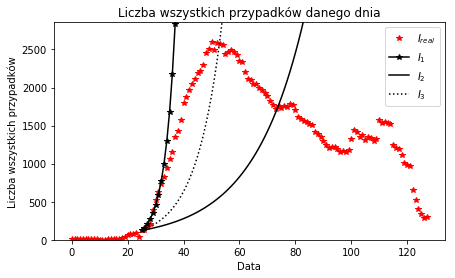

In [311]:
plt.figure(figsize=(7,4))

rt = r0

I_r0 = compute_SIR(Itotal[25],Rtotal[15],beta0, gamma0, t_max=200)
I_r1 = compute_SIR(Itotal[25],Rtotal[15],beta1, gamma2, t_max=200)
I_r2 = compute_SIR(Itotal[25],Rtotal[15],beta2, gamma2, t_max=200)

plt.ylim(0,1.1*np.max(Itotal))

plt.plot(Itotal,'r*', label=r'$I_{real}$')
plt.plot(np.arange(25,len(Itotal)),I_r0[:len(Itotal)-25],'k*-', label=r'$I_{1}$')
plt.plot(np.arange(25,len(Itotal)),I_r1[:len(Itotal)-25],'k-', label=r'$I_{2}$')
plt.plot(np.arange(25,len(Itotal)),I_r2[:len(Itotal)-25],'k:', label=r'$I_{3}$')

plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Data')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/maly_compare_r0.png', bbox_inches='tight')

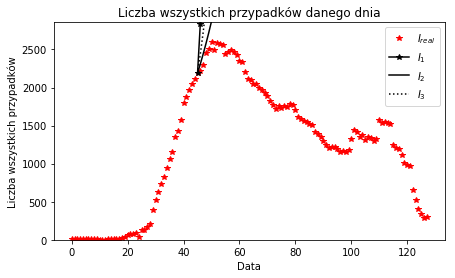

In [312]:
plt.figure(figsize=(7,4))

rt = r0

I_r0 = compute_SIR(Itotal[45],Rtotal[35],beta0, gamma0, t_max=200)
I_r1 = compute_SIR(Itotal[45],Rtotal[35],beta1, gamma2, t_max=200)
I_r2 = compute_SIR(Itotal[45],Rtotal[35],beta2, gamma2, t_max=200)

plt.ylim(0,1.1*np.max(Itotal))

plt.plot(Itotal,'r*', label=r'$I_{real}$')
plt.plot(np.arange(45,len(Itotal)),I_r0[:len(Itotal)-45],'k*-', label=r'$I_{1}$')
plt.plot(np.arange(45,len(Itotal)),I_r1[:len(Itotal)-45],'k-', label=r'$I_{2}$')
plt.plot(np.arange(45,len(Itotal)),I_r2[:len(Itotal)-45],'k:', label=r'$I_{3}$')

plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Data')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/maly_compare_r1.png', bbox_inches='tight')

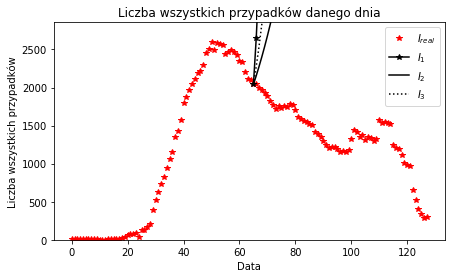

In [313]:
plt.figure(figsize=(7,4))

rt = r0

I_r0 = compute_SIR(Itotal[65],Rtotal[55],beta0, gamma0, t_max=200)
I_r1 = compute_SIR(Itotal[65],Rtotal[55],beta1, gamma2, t_max=200)
I_r2 = compute_SIR(Itotal[65],Rtotal[55],beta2, gamma2, t_max=200)

plt.ylim(0,1.1*np.max(Itotal))

plt.plot(Itotal,'r*', label=r'$I_{real}$')
plt.plot(np.arange(65,len(Itotal)),I_r0[:len(Itotal)-65],'k*-', label=r'$I_{1}$')
plt.plot(np.arange(65,len(Itotal)),I_r1[:len(Itotal)-65],'k-', label=r'$I_{2}$')
plt.plot(np.arange(65,len(Itotal)),I_r2[:len(Itotal)-65],'k:', label=r'$I_{3}$')

plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Data')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/maly_compare_r2.png', bbox_inches='tight')

## Belgium

In [285]:
N = 31*10**6

In [286]:
names, datas, dates = get_data(bg)

datas shape: (11, 128)
0 Currently Infected
1 Death Rate
2 Cases
3 Cases
4 Daily Cases
5 Currently Infected
6 Deaths
7 Deaths
8 Daily Deaths
9 New Recoveries
10 Death Rate


In [287]:
Itotal = datas[0]
Rtotal = np.cumsum(datas[9]) + np.cumsum(datas[8])

Idaily = datas[4]
Rdaily = datas[-3] + datas[-2]

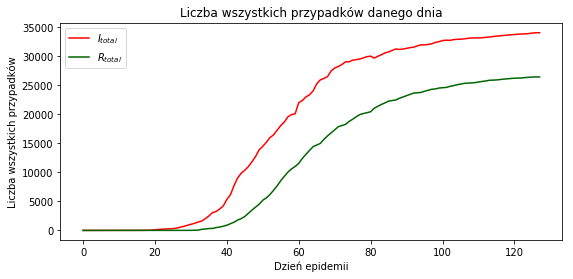

In [288]:
plt.figure(figsize=(9,4))
#np.cumsum(Idaily)-Dtotal-Rtotal
plt.plot(Itotal,'r', label=r'$I_{total}$')
plt.plot(Rtotal, 'darkgreen', label=r'$R_{total}$')

#plt.plot(np.cumsum(datas[9]), 'g', label=r'$R$')
#plt.plot(np.cumsum(datas[8]), 'k', label=r'$D$')

plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Dzień epidemii')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/belgium_total.png', bbox_inches='tight')

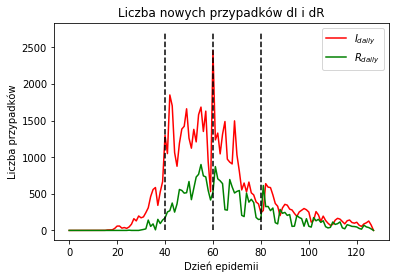

In [289]:
y = Idaily
x = np.arange(0,Rdaily.shape[0])

plt.plot(Idaily,'r', label=r'$I_{daily}$')
plt.plot(Rdaily, 'g', label=r'$R_{daily}$')

plt.plot([40,40],[0,1.1*np.max(Idaily)],'k--')
plt.plot([60,60],[0,1.1*np.max(Idaily)],'k--')
plt.plot([80,80],[0,1.1*np.max(Idaily)],'k--')

plt.legend()
plt.title('Liczba nowych przypadków dI i dR')
plt.xlabel('Dzień epidemii')
plt.ylabel('Liczba przypadków')

plt.savefig('images/belgium_fit.png', bbox_inches='tight')

In [290]:
N = 11*10**6

In [291]:
dI = np.array([np.mean(Idaily[34:37]), np.mean(Idaily[54:57]), np.mean(Idaily[74:77])])
dR = np.array([np.mean(Rdaily[24:27]), np.mean(Rdaily[44:47]), np.mean(Rdaily[64:67])])
eI = np.array([np.max(Idaily[34:37])-np.min(Idaily[34:37]), 
               np.max(Idaily[54:57])-np.min(Idaily[54:57]),  
               np.max(Idaily[74:77])-np.min(Idaily[74:77])])/2/np.sqrt(3)
eR = np.array([np.max(Rdaily[24:27])-np.min(Rdaily[24:27]), 
               np.max(Rdaily[44:47])-np.min(Rdaily[44:47]),  
               np.max(Rdaily[64:67])-np.min(Rdaily[64:67])])/2/np.sqrt(3)

In [292]:
ge = eR/Itotal[[35,55,75]]
be = np.sqrt( (eI/Itotal[[25,45,65]])**2 + ge**2 )

In [293]:
Itab = []
for i, nt in enumerate([40,60,80]):
    dValuse = [[dI1,dR1],
              [dI2,dR2],
              [dI3,dR3]]
    S, I, R  = SIR(Itotal[nt-5],Rtotal[nt-15], N,
                   dValuse[i][0],dValuse[i][1],
                   t_max=400)
    Itab.append(I)
print(be)
print(ge)

beta = 0.012880176843305856
gamma = 0.0
beta = 0.007092851617802078
gamma = 0.000165929203539823
beta = 0.007902457114486535
gamma = 0.00030665440049064706
[0.11547058 0.01049789 0.00393702]
[0.0003485  0.00493366 0.00356061]


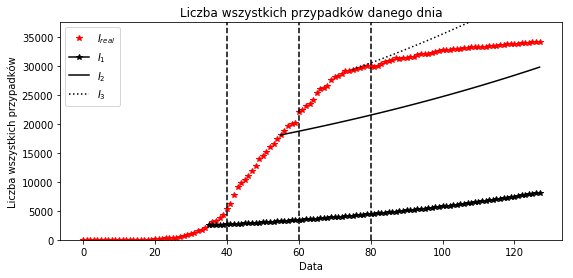

In [294]:
plt.figure(figsize=(9,4))
#np.cumsum(Idaily)-Dtotal-Rtotal
plt.plot(Itotal,'r*', label=r'$I_{real}$')
plt.plot(np.arange(35,len(Itotal)),Itab[0][:len(Itotal)-35],'k-*', label=r'$I_{1}$')
plt.plot(np.arange(55,len(Itotal)),Itab[1][:len(Itotal)-55],'k-', label=r'$I_{2}$')
plt.plot(np.arange(75,len(Itotal)),Itab[2][:len(Itotal)-75],'k:', label=r'$I_{3}$')

plt.plot([40,40],[0,1.1*np.max(Itotal)],'k--')
plt.plot([60,60],[0,1.1*np.max(Itotal)],'k--')
plt.plot([80,80],[0,1.1*np.max(Itotal)],'k--')

plt.ylim(0,1.1*np.max(Itotal))
plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Data')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/belgium_compare.png', bbox_inches='tight')

In [296]:
beta0 = 0.012880176843305856
gamma0 = 0.0
beta1 = 0.007092851617802078
gamma1 = 0.000165929203539823
beta2 = 0.007902457114486535
gamma2 = 0.00030665440049064706

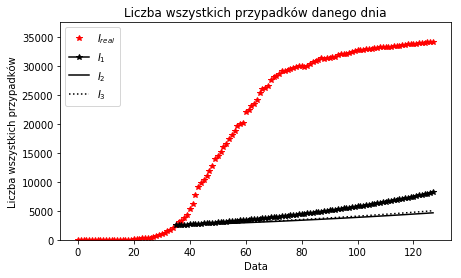

In [297]:
plt.figure(figsize=(7,4))

rt = r0

I_r0 = compute_SIR(Itotal[35],Rtotal[25],beta0, gamma0, t_max=200)
I_r1 = compute_SIR(Itotal[35],Rtotal[25],beta1, gamma2, t_max=200)
I_r2 = compute_SIR(Itotal[35],Rtotal[25],beta2, gamma2, t_max=200)

plt.ylim(0,1.1*np.max(Itotal))

plt.plot(Itotal,'r*', label=r'$I_{real}$')
plt.plot(np.arange(35,len(Itotal)),I_r0[:len(Itotal)-35],'k*-', label=r'$I_{1}$')
plt.plot(np.arange(35,len(Itotal)),I_r1[:len(Itotal)-35],'k-', label=r'$I_{2}$')
plt.plot(np.arange(35,len(Itotal)),I_r2[:len(Itotal)-35],'k:', label=r'$I_{3}$')

plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Data')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/malysia_compare_r0.png', bbox_inches='tight')

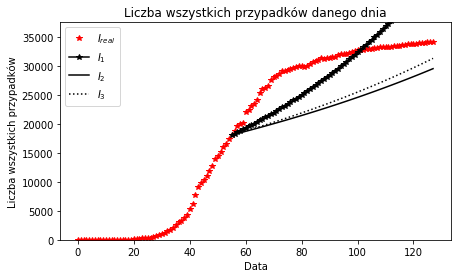

In [298]:
plt.figure(figsize=(7,4))

rt = r0

I_r0 = compute_SIR(Itotal[55],Rtotal[45],beta0, gamma0, t_max=200)
I_r1 = compute_SIR(Itotal[55],Rtotal[45],beta1, gamma2, t_max=200)
I_r2 = compute_SIR(Itotal[55],Rtotal[45],beta2, gamma2, t_max=200)

plt.ylim(0,1.1*np.max(Itotal))

plt.plot(Itotal,'r*', label=r'$I_{real}$')
plt.plot(np.arange(55,len(Itotal)),I_r0[:len(Itotal)-55],'k*-', label=r'$I_{1}$')
plt.plot(np.arange(55,len(Itotal)),I_r1[:len(Itotal)-55],'k-', label=r'$I_{2}$')
plt.plot(np.arange(55,len(Itotal)),I_r2[:len(Itotal)-55],'k:', label=r'$I_{3}$')

plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Data')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/malysia_compare_r1.png', bbox_inches='tight')

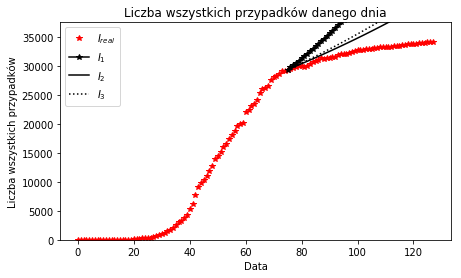

In [299]:
plt.figure(figsize=(7,4))

rt = r0

I_r0 = compute_SIR(Itotal[75],Rtotal[65],beta0, gamma0, t_max=200)
I_r1 = compute_SIR(Itotal[75],Rtotal[65],beta1, gamma2, t_max=200)
I_r2 = compute_SIR(Itotal[75],Rtotal[65],beta2, gamma2, t_max=200)

plt.ylim(0,1.1*np.max(Itotal))

plt.plot(Itotal,'r*', label=r'$I_{real}$')
plt.plot(np.arange(75,len(Itotal)),I_r0[:len(Itotal)-75],'k*-', label=r'$I_{1}$')
plt.plot(np.arange(75,len(Itotal)),I_r1[:len(Itotal)-75],'k-', label=r'$I_{2}$')
plt.plot(np.arange(75,len(Itotal)),I_r2[:len(Itotal)-75],'k:', label=r'$I_{3}$')

plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Data')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/malysia_compare_r2.png', bbox_inches='tight')